In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['MPLBACKEND'] = 'TKAgg'

from sarix import sarix
import numpy as np
import pandas as pd
# matplotlib.use('TkAgg')
%matplotlib inline
from matplotlib import pyplot as plt
import covidcast
from datetime import date

In [2]:
def load_data(geo_values = "ma", as_of = None, end_day = "2021-07-01"):
    """
    Load data for Change healthcare CLI, cases, and hosps from covidcast
    
    Parameters
    ----------
    as_of: string of date in YYYY-MM-DD format.
        Default to None.
    end_day: string of date in YYYY-MM-DD format.
        Default to "2021-07-01"
    
    Returns
    -------
    df: data frame
        It has columns location, date, inc_hosp, population and rate.
        It is sorted by location and date columns in ascending order.
    """
    # load hospitalizations
    hosp_df = covidcast.signal(data_source="hhs",
                               signal="confirmed_admissions_covid_1d",
                               start_day=date.fromisoformat("2020-10-01"),
                               end_day=date.fromisoformat(end_day),
                               geo_type="state",
                               geo_values=geo_values,
                               as_of=as_of)
    hosp_df = hosp_df[["geo_value", "time_value", "value"]]
    hosp_df.columns = ["location", "date", "hosp"]
    
    # load cases
    case_df = covidcast.signal(data_source="jhu-csse",
                          signal="confirmed_incidence_num",
                          start_day=date.fromisoformat("2020-10-01"),
                          end_day=date.fromisoformat(end_day),
                          geo_type="state",
                          geo_values=geo_values,
                          as_of=None)
    case_df = case_df[["geo_value", "time_value", "value"]]
    case_df.columns = ["location", "date", "case"]
    
    # load cases
    change_cli_df = covidcast.signal(data_source="chng",
                          signal="smoothed_outpatient_cli",
                          start_day=date.fromisoformat("2020-10-01"),
                          end_day=date.fromisoformat(end_day),
                          geo_type="state",
                          geo_values=geo_values,
                          as_of=None)
    change_cli_df = change_cli_df[["geo_value", "time_value", "value"]]
    change_cli_df.columns = ["location", "date", "change_cli"]
    
    # merge
    df = case_df.merge(hosp_df, on=["location", "date"], how = "left") \
        .merge(change_cli_df, on=["location", "date"], how = "left")

    # sort
    df = df.sort_values(['location', 'date'])

    return df

df = load_data(geo_values = ["ma", "ca", "pa"], end_day="2021-06-01")
df

,location,date,case,hosp,change_cli
0,ca,2020-10-01,3506.0,316.0,4.929400
3,ca,2020-10-02,4148.0,328.0,4.970151
6,ca,2020-10-03,4257.0,294.0,5.390648
9,ca,2020-10-04,2785.0,315.0,6.488778
12,ca,2020-10-05,1853.0,347.0,6.343796
...,...,...,...,...,...
719,pa,2021-05-28,1066.0,119.0,1.439242
722,pa,2021-05-29,842.0,102.0,1.312694
725,pa,2021-05-30,516.0,94.0,1.375940
728,pa,2021-05-31,421.0,90.0,1.513397


In [3]:
# helper function to plot all signals by location
def plot_by_loc(df, var_names):
  locs = df.location.unique()
  num_locs = len(locs)
  num_vars = len(var_names)
  fig, ax = plt.subplots(num_vars, num_locs, figsize = (num_locs * 4, num_vars * 2), squeeze=False)
  for i, var_name in enumerate(var_names):
    for j, loc in enumerate(locs):
      ax[i, j].plot(df[df.location == loc][[var_name]])
      ax[i, j].title.set_text(loc + ', ' + var_name)
  
  plt.tight_layout()

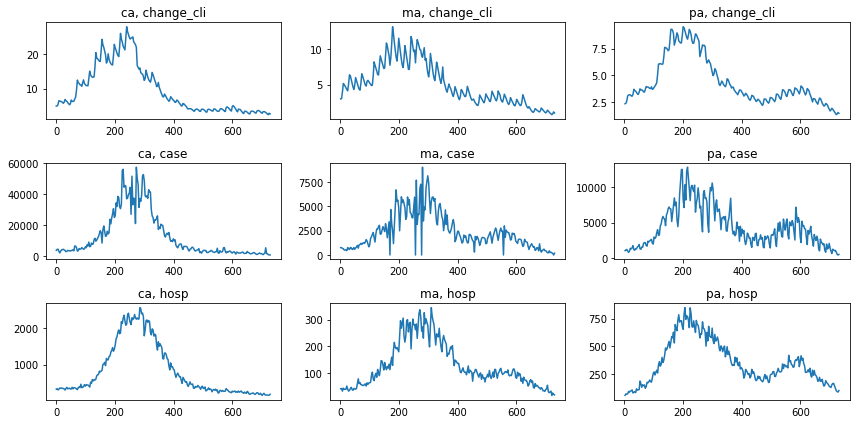

In [4]:
plot_by_loc(df, ['change_cli', 'case', 'hosp'])

/home/eray/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


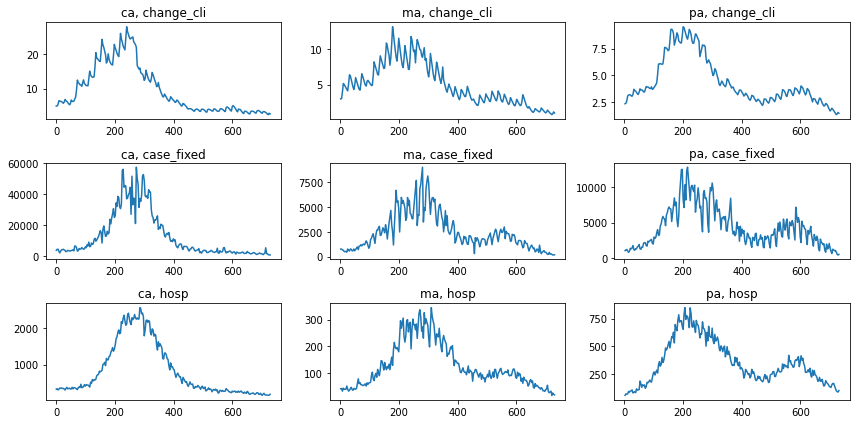

In [32]:
# quick fix to zero values; mean of adjacent
df['case_fixed'] = df.case
zero_inds = np.where(df.case == 0)
df['case_fixed'].iloc[zero_inds] = 0.5 * (df['case_fixed'].iloc[zero_inds[0] - 1].values + df['case_fixed'].iloc[zero_inds[0] + 1].values)
plot_by_loc(df, ['change_cli', 'case_fixed', 'hosp'])

In [131]:
# helper function to plot forecasts
def plot_forecasts(model_fit, var_names):
    T_orig = model_fit.xy_orig.shape[0]
    T = model_fit.xy.shape[0]
    t_orig = np.arange(T_orig)
    t_transformed = np.arange(T) + T_orig - T
    t_pred = T_orig - 50 + np.arange(model_fit.forecast_horizon)
    
    percentile_levels = [2.5, 97.5]
    median_prediction = np.median(model_fit.predictions_modeled_scale, axis=0)
    percentiles = np.percentile(model_fit.predictions_modeled_scale, percentile_levels, axis=0)
    median_prediction_orig = np.median(model_fit.predictions, axis=0)
    percentiles_orig = np.percentile(model_fit.predictions, percentile_levels, axis=0)
    
    fig, ax = plt.subplots(2 * len(var_names), 1, figsize=(10,3 * 2 * len(var_names)))
    
    for (i, var_name) in enumerate(var_names):
        ax[0 + i*2].fill_between(t_pred, percentiles_orig[0, :, i], percentiles_orig[1, :, i], color='lightblue')
        ax[0 + i*2].plot(t_pred, median_prediction_orig[:, i], 'blue', ls='solid', lw=2.0)
        ax[0 + i*2].plot(t_orig, model_fit.xy_orig[:, i], 'black', ls='solid')
        ax[0 + i*2].set(xlabel="t", ylabel=var_name, title="Mean predictions with 95% CI")
        
        ax[1 + i*2].fill_between(t_pred, percentiles[0, :, i], percentiles[1, :, i], color='lightblue')
        ax[1 + i*2].plot(t_pred, median_prediction[:, i], 'blue', ls='solid', lw=2.0)
        ax[1 + i*2].plot(t_transformed, model_fit.xy[:, i], 'black', ls='solid')
        ax[1 + i*2].set(xlabel="t", ylabel=var_name + " (" + model_fit.transform + " scale)", title="Mean predictions with 95% CI")
    
    plt.tight_layout()
    plt.show()


In [245]:
# quick reload for debug
from importlib import reload
sarix = reload(sarix)

In [246]:
df_ma = df[df.location == 'ma']
sarix_fit_hosp_only = sarix.SARIX(
    xy = df_ma[["hosp"]].values[:-50],
    p = 3,
    d = 0,
    P = 0,
    D = 0,
    season_period = 7,
    transform = "fourthrt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)


sample: 100%|██████████| 2000/2000 [00:03<00:00, 526.93it/s, 255 steps of size 2.09e-02. acc. prob=0.93]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
ar_update_sd[0]      0.13      0.01      0.13      0.11      0.14    643.52      1.00
       theta[0]      0.75      0.07      0.75      0.64      0.87    468.48      1.00
       theta[1]     -0.01      0.09     -0.01     -0.14      0.15    386.79      1.00
       theta[2]      0.26      0.07      0.26      0.15      0.37    597.59      1.00
    theta_sd[0]      0.66      0.36      0.56      0.23      1.09    459.13      1.00

Number of divergences: 0

MCMC elapsed time: 3.914320707321167


<ipython-input-131-93a3cbff938f>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


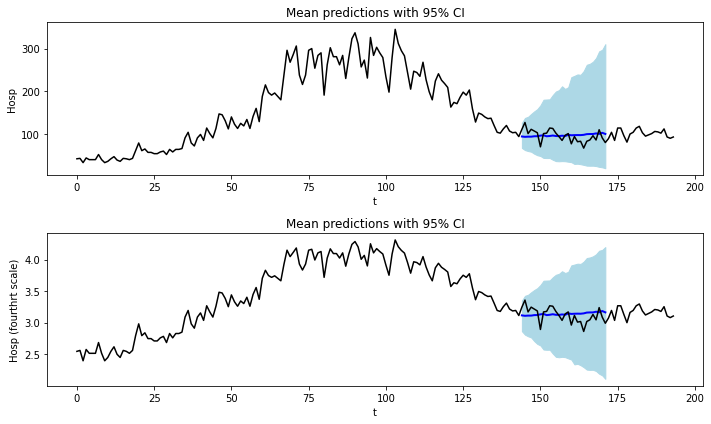

In [247]:
plot_forecasts(sarix_fit_hosp_only, ['Hosp'])

In [248]:
df

,location,date,case,hosp,change_cli,case_fixed
0,ca,2020-10-01,3506.0,316.0,4.929400,3506.0
3,ca,2020-10-02,4148.0,328.0,4.970151,4148.0
6,ca,2020-10-03,4257.0,294.0,5.390648,4257.0
9,ca,2020-10-04,2785.0,315.0,6.488778,2785.0
12,ca,2020-10-05,1853.0,347.0,6.343796,1853.0
...,...,...,...,...,...,...
719,pa,2021-05-28,1066.0,119.0,1.439242,1066.0
722,pa,2021-05-29,842.0,102.0,1.312694,842.0
725,pa,2021-05-30,516.0,94.0,1.375940,516.0
728,pa,2021-05-31,421.0,90.0,1.513397,421.0


In [249]:
sarix_fit_cases = sarix.SARIX(
    xy = df_ma[["case_fixed", "hosp"]].values[:-50],
    p = 14,
    d = 0,
    P = 0,
    D = 0,
    season_period = 7,
    transform = "fourthrt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:23<00:00, 84.10it/s, 511 steps of size 7.07e-03. acc. prob=0.93]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
ar_update_sd[0]      0.41      0.02      0.41      0.37      0.44   1409.41      1.00
ar_update_sd[1]      0.10      0.01      0.10      0.09      0.11   1073.86      1.00
       theta[0]      0.38      0.07      0.38      0.27      0.49    947.43      1.00
       theta[1]      0.16      0.07      0.16      0.04      0.26   1008.83      1.00
       theta[2]      0.02      0.07      0.02     -0.09      0.13    981.31      1.00
       theta[3]      0.09      0.07      0.09     -0.02      0.22    906.41      1.00
       theta[4]      0.11      0.07      0.11      0.00      0.23    960.24      1.00
       theta[5]      0.18      0.07      0.18      0.06      0.29    822.55      1.00
       theta[6]      0.36      0.08      0.36      0.23      0.47    683.47      1.00
       theta[7]      0.03      0.07      0.03     -0.11      0.13    939.85      1.00
       theta[8]     -0.17      0.07     -0.17     -0.

<ipython-input-131-93a3cbff938f>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


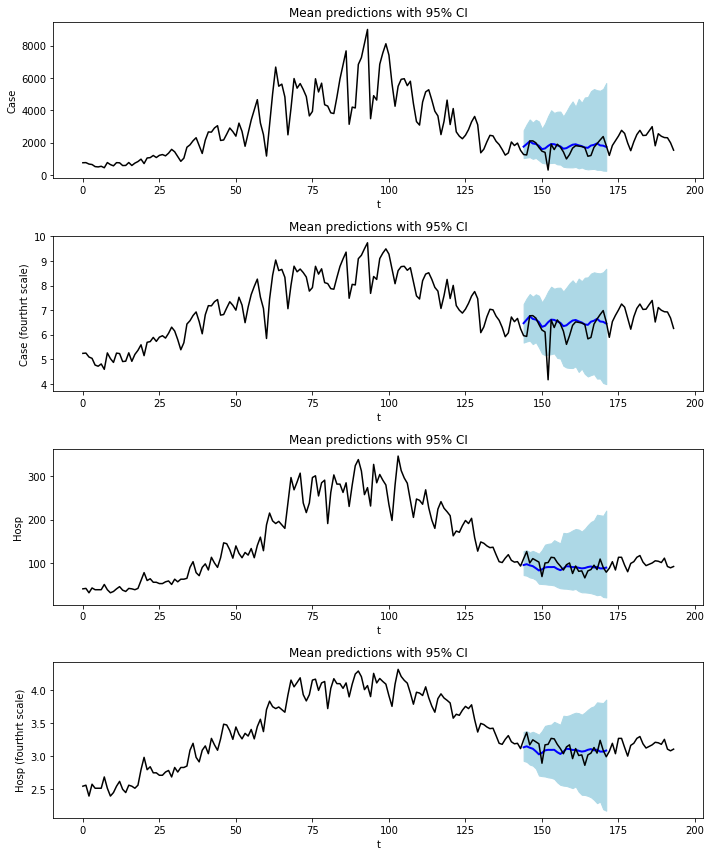

In [250]:
plot_forecasts(sarix_fit_cases, ['Case', 'Hosp'])

In [251]:
sarix_fit_cli_cases = sarix.SARIX(
    xy = df_ma[["change_cli", "case_fixed", "hosp"]].values[:-50],
    p = 2,
    d = 0,
    P = 1,
    D = 0,
    season_period = 7,
    transform = "fourth_rt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:09<00:00, 206.66it/s, 127 steps of size 3.04e-02. acc. prob=0.92]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
ar_update_sd[0]      0.47      0.02      0.47      0.43      0.51   1407.07      1.00
ar_update_sd[1]    671.95     36.55    670.59    621.64    739.99   1823.95      1.00
ar_update_sd[2]     18.84      1.09     18.78     17.09     20.49   1453.52      1.00
       theta[0]      0.91      0.07      0.91      0.79      1.02    469.30      1.00
       theta[1]     -0.02      0.07     -0.02     -0.14      0.09    421.59      1.00
       theta[2]      0.79      0.04      0.79      0.72      0.86   1412.99      1.00
       theta[3]     -0.59      0.09     -0.59     -0.75     -0.45    529.61      1.00
       theta[4]     -0.09      0.07     -0.09     -0.21      0.02    448.49      1.00
       theta[5]      0.47      0.07      0.47      0.35      0.58    932.40      1.00
       theta[6]      0.24      0.07      0.24      0.13      0.36    621.70      1.00
       theta[7]      0.64      0.06      0.64      0.

<ipython-input-131-93a3cbff938f>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


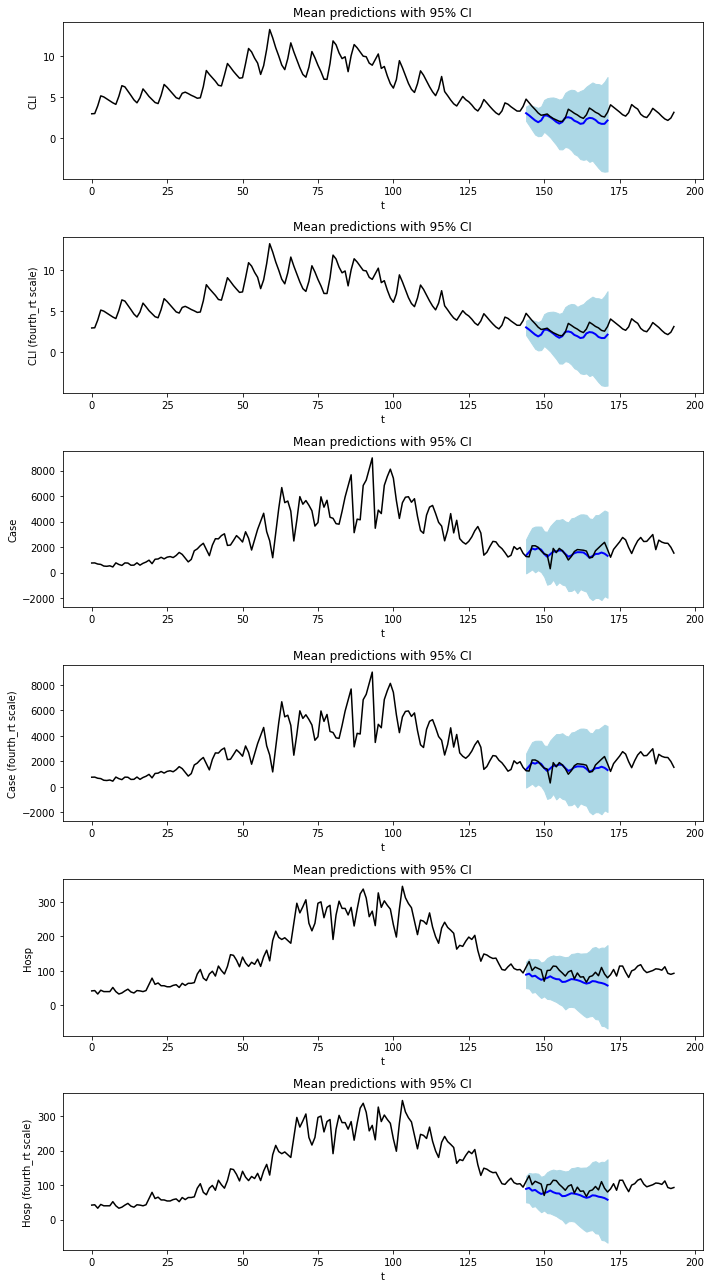

In [252]:
plot_forecasts(sarix_fit_cli_cases, ['CLI', 'Case', 'Hosp'])

In [254]:
sarix_fit_cli_cases_differenced = sarix.SARIX(
    xy = df_ma[["change_cli", "case_fixed", "hosp"]].values[:-50],
    p = 2,
    d = 0,
    P = 1,
    D = 1,
    season_period = 7,
    transform = "fourth_rt",
    forecast_horizon = 28,
    num_warmup = 1000,
    num_samples = 1000,
    num_chains = 1)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 429.76it/s, 15 steps of size 2.05e-01. acc. prob=0.92]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
ar_update_sd[0]      0.48      0.03      0.48      0.45      0.53    952.86      1.00
ar_update_sd[1]    736.56     40.79    733.69    679.02    808.31   1328.20      1.00
ar_update_sd[2]     20.50      1.10     20.40     18.78     22.43   1229.30      1.00
       theta[0]      0.87      0.08      0.87      0.75      1.00    566.66      1.00
       theta[1]      0.05      0.08      0.05     -0.08      0.18    539.53      1.00
       theta[2]     -0.29      0.07     -0.29     -0.40     -0.17    830.66      1.00
       theta[3]      0.27      0.10      0.26      0.11      0.42    432.42      1.00
       theta[4]     -0.05      0.07     -0.05     -0.18      0.07    536.77      1.00
       theta[5]      0.35      0.07      0.34      0.23      0.46    812.69      1.00
       theta[6]      0.27      0.08      0.27      0.14      0.39    803.51      1.00
       theta[7]     -0.16      0.07     -0.16     -0.

<ipython-input-131-93a3cbff938f>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


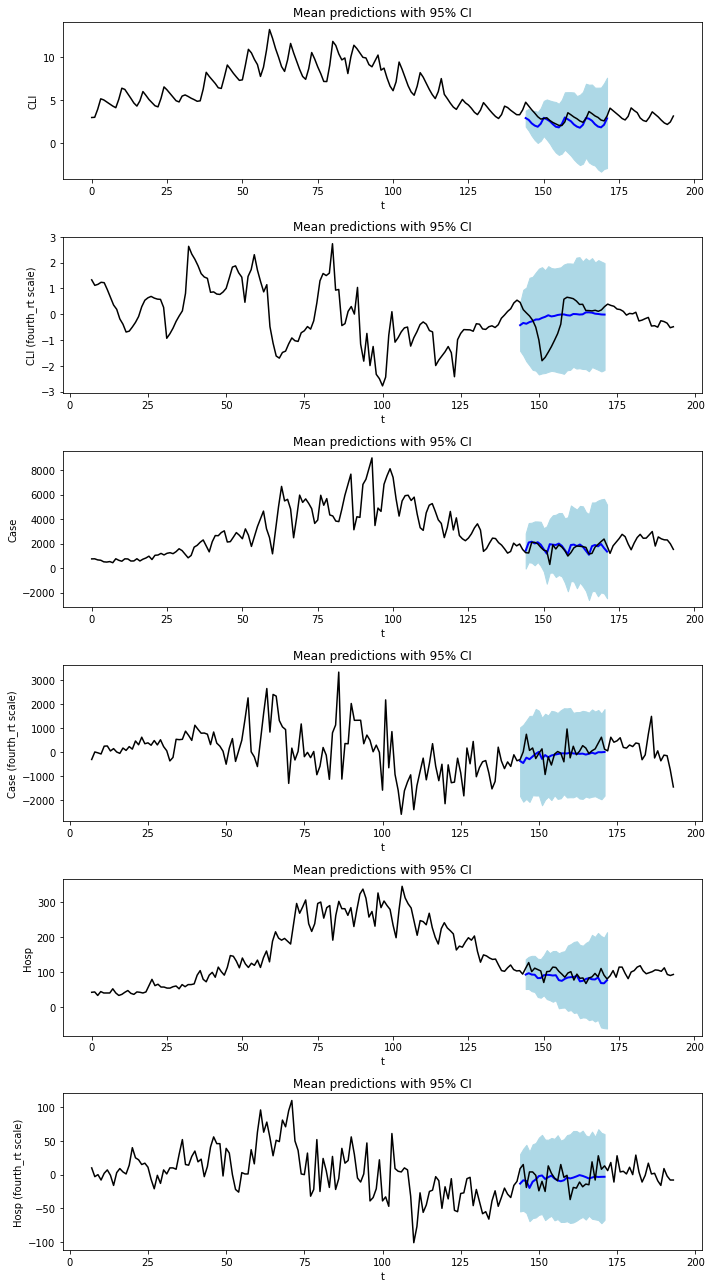

In [255]:
plot_forecasts(sarix_fit_cli_cases_differenced, ['CLI', 'Case', 'Hosp'])